## Putting Data on a Map

Often, we want to put data in a `pandas` dataframe directly on a map - here's how!

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import ptolemy as pt

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")
ds["lon"] = ds.lon - 360  # change from degrees_east to centered at prime meridian
grid = ds.air.isel(time=1)
url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson"

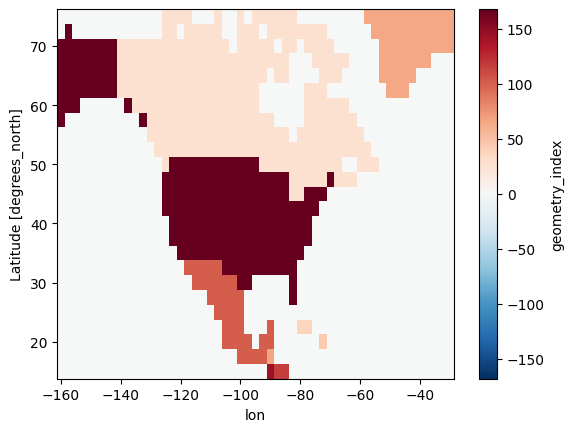

In [3]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="adm0_a3")
idxr = r.rasterize(strategy="majority", verbose=True)
idxr.plot()

In [4]:
idx_map = {v: int(k) for k, v in idxr.attrs.items() if int(k) in np.unique(idxr)}
idx_map

{'CAN': 27,
 'CUB': 37,
 'DOM': 44,
 'GRL': 65,
 'GTM': 66,
 'MEX': 102,
 'NIC': 116,
 'SLV': 144,
 'USA': 168}

In [5]:
df = pd.DataFrame(
    {
        "adm0_a3": ["USA"] * 2 + ["MEX"] * 2,
        "year": [2015, 2020] * 2,
        "data": [15, 20, 5, 10],
    }
)
df

,adm0_a3,year,data
0,USA,2015,15
1,USA,2020,20
2,MEX,2015,5
3,MEX,2020,10


In [6]:
ds = pt.df_to_raster(df, idxr, "adm0_a3", idx_map, coords=["year"])
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, year: 2)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 -160.0 -157.5 -155.0 -152.5 ... -35.0 -32.5 -30.0
  * year     (year) int64 2015 2020
Data variables:
    data     (lat, lon, year) float64 nan nan nan nan nan ... nan nan nan nan

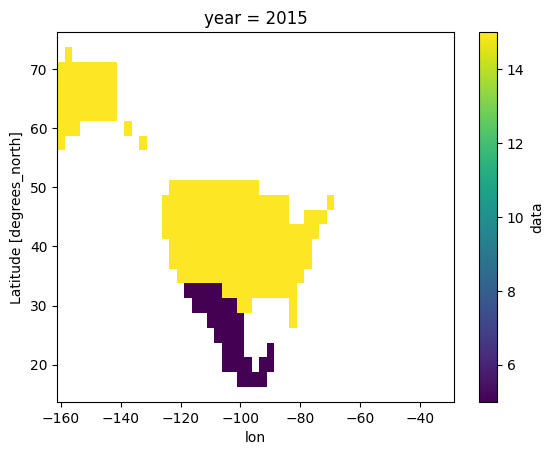

In [7]:
ds.data.sel(year=2015).plot()

## Applying data to multiple raster layers

In many applications, we actually have a single raster layer for each shape we are rasterizing which corresponds to the percent of the grid cell covered by that shape. That was shown in our [introduction tutorial](https://ptolemy-iamc.readthedocs.io/en/latest/notebooks/introduction.html#Percent-of-area-rasters), which we repeat here:

In [8]:
r = pt.Rasterize(like=grid)
r.read_shpf(url, idxkey="adm0_a3")
idxr_w = r.rasterize(strategy="weighted", verbose=True)

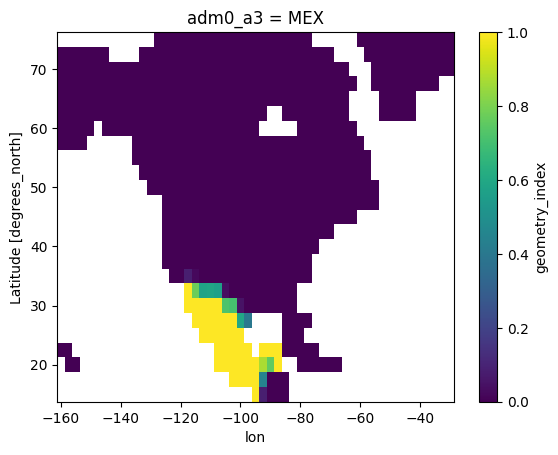

In [9]:
idxr_w.sel(adm0_a3="MEX").plot()

You can then apply data to your map based on these weighted raster layers directly.

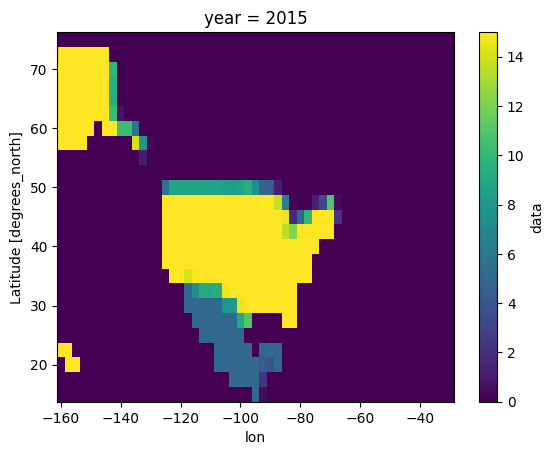

In [10]:
ds_w = pt.df_to_weighted_raster(df, idxr_w, extra_coords=["year"], sum_dim=["adm0_a3"])
ds_w.data.sel(year=2015).plot()

## Getting data from a map (Zonal Statistics)

Using the tools developed so far, we can also get data corresponding to different shape areas (i.e., zonal statistics). For that, we need to provide the data to extract and mapping information from the index rasters.

In [11]:
pt.raster_to_df(ds, idxr, idx_map=idx_map, idx_dim="adm0_a3", func="max")

,year,adm0_a3,data
0,2015,MEX,5.0
1,2015,USA,15.0
2,2020,MEX,10.0
3,2020,USA,20.0


In [12]:
pt.raster_to_df(ds, idxr, idx_map=idx_map, idx_dim="adm0_a3", func="sum")

,year,adm0_a3,data
0,2015,MEX,170.0
1,2015,USA,2685.0
2,2020,MEX,340.0
3,2020,USA,3580.0


Similarly, `raster_to_df()` supports weighted rasters **but** these need to be applied carefully as they can **overlap multiple shapes**

In [13]:
pt.raster_to_df(ds, idxr_w, func="max")

,year,adm0_a3,data
0,2015,BLZ,0.849057
1,2015,CAN,8.571428
2,2015,GTM,2.745902
3,2015,MEX,5.000000
4,2015,USA,15.000000
5,2020,BLZ,1.698113
6,2020,CAN,11.428571
7,2020,GTM,5.491803
8,2020,MEX,10.000000
9,2020,USA,20.000000


In [14]:
pt.raster_to_df(ds, idxr_w, func="mean")

,year,adm0_a3,data
0,2015,BLZ,0.003986
1,2015,CAN,0.628625
2,2015,GTM,0.017635
3,2015,MEX,0.731777
4,2015,USA,12.021734
5,2020,BLZ,0.007972
6,2020,CAN,0.838166
7,2020,GTM,0.035269
8,2020,MEX,1.454658
9,2020,USA,16.067691
